# 前言
现如今，共享单车在生活中可谓处处可见，那么它的租赁需求是多少呢？今天我们就基于美国华盛顿共享单车的租赁数据，对租赁需求进行预测

# 正文
1. 数据来源及背景
数据来源: https://www.kaggle.com/c/bike-sharing-demand/data,
https://www.cnblogs.com/star-zhao/p/10140034.html
数据背景: 该数据集是美国华盛顿共享单车租赁数据, 其中有训练集和测试集, 在训练集中包含10886个样本以及12个字段, 通过训练集上自行车租赁数据对美国华盛顿共享单车租赁需求进行预测. 

# 2. 数据探索分析
1. 读取数据

In [1]:
import pandas as pd
import numpy  as np
import matplotlib.pyplot as plt

In [2]:
df=pd.read_csv('train.csv')
pd.set_option('display.max_rows',4)
df

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0000,3,13,16
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0000,8,32,40
...,...,...,...,...,...,...,...,...,...,...,...,...
10884,2012-12-19 22:00:00,4,0,1,1,13.94,17.425,61,6.0032,12,117,129
10885,2012-12-19 23:00:00,4,0,1,1,13.12,16.665,66,8.9981,4,84,88


2. 查看数据整体信息

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10886 entries, 0 to 10885
Data columns (total 12 columns):
datetime      10886 non-null object
season        10886 non-null int64
holiday       10886 non-null int64
workingday    10886 non-null int64
weather       10886 non-null int64
temp          10886 non-null float64
atemp         10886 non-null float64
humidity      10886 non-null int64
windspeed     10886 non-null float64
casual        10886 non-null int64
registered    10886 non-null int64
count         10886 non-null int64
dtypes: float64(3), int64(8), object(1)
memory usage: 1020.6+ KB


3. 描述性统计

In [4]:
pd.set_option('display.max_rows',None)
df.describe()

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
count,10886.000000,10886.000000,10886.000000,10886.000000,10886.00000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000
mean,2.506614,0.028569,0.680875,1.418427,20.23086,23.655084,61.886460,12.799395,36.021955,155.552177,191.574132
std,1.116174,0.166599,0.466159,0.633839,7.79159,8.474601,19.245033,8.164537,49.960477,151.039033,181.144454
min,1.000000,0.000000,0.000000,1.000000,0.82000,0.760000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,2.000000,0.000000,0.000000,1.000000,13.94000,16.665000,47.000000,7.001500,4.000000,36.000000,42.000000
50%,3.000000,0.000000,1.000000,1.000000,20.50000,24.240000,62.000000,12.998000,17.000000,118.000000,145.000000
75%,4.000000,0.000000,1.000000,2.000000,26.24000,31.060000,77.000000,16.997900,49.000000,222.000000,284.000000
max,4.000000,1.000000,1.000000,4.000000,41.00000,45.455000,100.000000,56.996900,367.000000,886.000000,977.000000


4. 偏态, 峰态

In [5]:
for i in df.columns[5:12]:
    print('{0}的偏态系数：{1},峰态系数：{2}'.format(i,df[i].skew(),df[i].kurt()))

temp的偏态系数：0.003690844422472008,峰态系数：-0.9145302637630794
atemp的偏态系数：-0.10255951346908665,峰态系数：-0.8500756471754651
humidity的偏态系数：-0.08633518364548581,峰态系数：-0.7598175375208864
windspeed的偏态系数：0.5887665265853944,峰态系数：0.6301328693364932
casual的偏态系数：2.4957483979812567,峰态系数：7.551629305632764
registered的偏态系数：1.5248045868182296,峰态系数：2.6260809999210672
count的偏态系数：1.2420662117180776,峰态系数：1.3000929518398334


# 3. 数据预处理
由于没有缺失值, 不用处理缺失值, 看看有没有重复值.

1. 检查重复值

In [6]:
print('未去重: ',df.shape)
print('去重： ',df.drop_duplicates().shape)

未去重:  (10886, 12)
去重：  (10886, 12)


2. 异常值

通过箱线图查看异常值

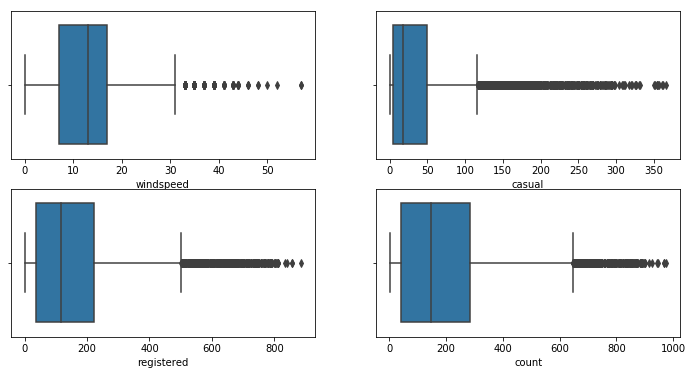

In [7]:
import seaborn as sns
fig,axes=plt.subplots(nrows=2, ncols=2,figsize=(12,6))
#绘制箱线图
sns.boxplot(x="windspeed", data=df,ax=axes[0][0])
sns.boxplot(x='casual', data=df, ax=axes[0][1])
sns.boxplot(x='registered', data=df, ax=axes[1][0])
sns.boxplot(x='count', data=df, ax=axes[1][1])
plt.show()

3. 数据加工 

转换"时间和日期"的格式, 并提取出小时, 日, 月, 年.

In [8]:
#转换格式, 并提取出小时, 星期几, 月份
df['datetime']=pd.to_datetime(df['datetime'])
df['hour']=df.datetime.dt.hour
df['week'] = df.datetime.dt.dayofweek
df['month'] = df.datetime.dt.month
df["year_month"]=df.datetime.dt.strftime('%Y-%m')
df['date'] = df.datetime.dt.date
#删除datetime
df.drop('datetime', axis = 1, inplace = True)
df.head()

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,hour,week,month,year_month,date
0,1,0,0,1,9.84,14.395,81,0.0,3,13,16,0,5,1,2011-01,2011-01-01
1,1,0,0,1,9.02,13.635,80,0.0,8,32,40,1,5,1,2011-01,2011-01-01
2,1,0,0,1,9.02,13.635,80,0.0,5,27,32,2,5,1,2011-01,2011-01-01
3,1,0,0,1,9.84,14.395,75,0.0,3,10,13,3,5,1,2011-01,2011-01-01
4,1,0,0,1,9.84,14.395,75,0.0,0,1,1,4,5,1,2011-01,2011-01-01


# 4. 可视化分析
1) 日期和总租赁数量

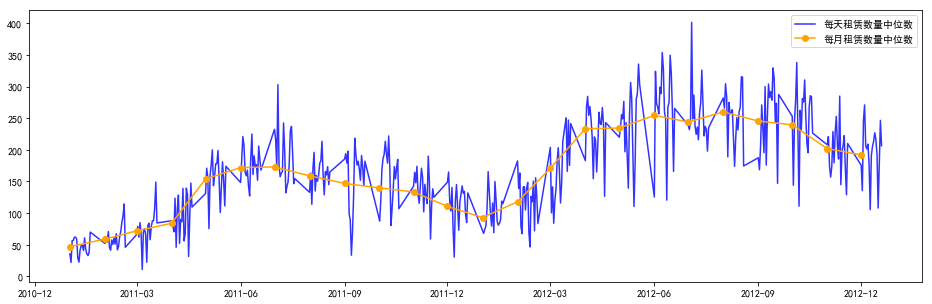

In [9]:
import matplotlib
#设置中文字体
font={'family':'SimHei'}
matplotlib.rc('font',**font)
#分别计算日期和月份中位数
group_date=df.groupby("date")["count"].median()
group_month = df.groupby('year_month')['count'].median()
group_month.index = pd.to_datetime(group_month.index)
plt.figure(figsize=(16,5))
plt.plot(group_date.index,group_date.values,'-',color='b',label="每天租赁数量中位数",alpha=0.8)
plt.plot(group_month.index,group_month.values,'-o',color='orange',label="每月租赁数量中位数")
plt.legend()
plt.show()

2) 月份和总租赁数量

<function matplotlib.pyplot.show(*args, **kw)>

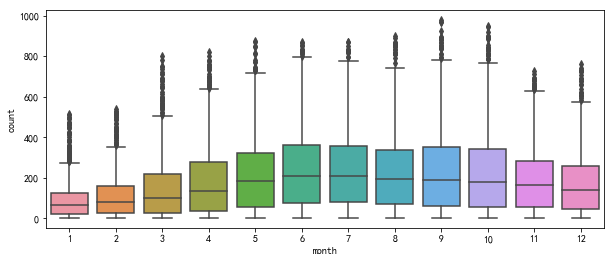

In [10]:
import seaborn as sns
plt.figure(figsize=(10,4))
sns.boxplot(x="month",y="count",data=df)
plt.show

3) 季节和总租赁数量

<function matplotlib.pyplot.show(*args, **kw)>

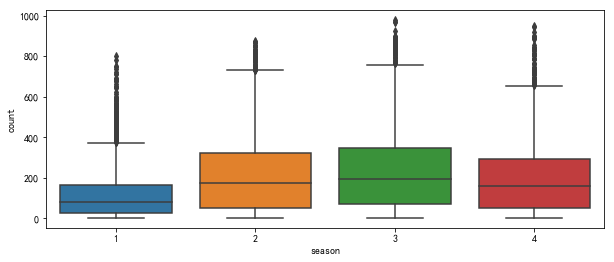

In [11]:
plt.figure(figsize=(10,4))
sns.boxplot(x="season",y="count",data=df)
plt.show

4) 星期几和租赁数量

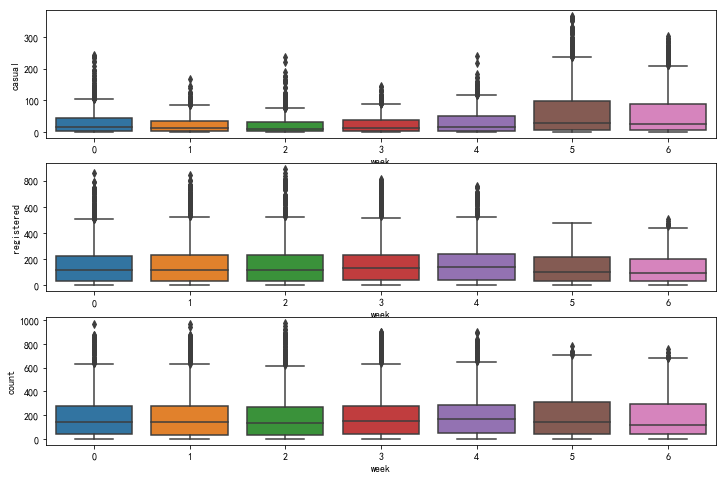

In [12]:
fig,axes=plt.subplots(nrows=3,ncols=1,figsize=(12,8))
sns.boxplot(x="week",y="casual",data=df,ax=axes[0])
sns.boxplot(x="week",y="registered",data=df,ax=axes[1])
sns.boxplot(x="week",y="count",data=df,ax=axes[2])
plt.show()

5) 节假日, 工作日和总租赁数量

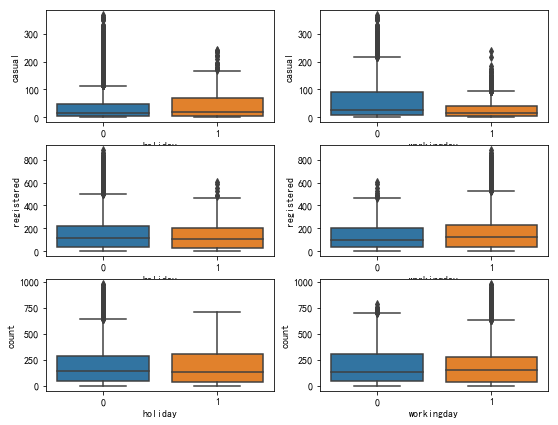

In [13]:
fig,axes=plt.subplots(nrows=3,ncols=2,figsize=(9,7))
sns.boxplot(x="holiday",y="casual",data=df,ax=axes[0][0])
sns.boxplot(x="holiday",y="registered",data=df,ax=axes[1][0])
sns.boxplot(x="holiday",y="count",data=df,ax=axes[2][0])
sns.boxplot(x="workingday",y="casual",data=df,ax=axes[0][1])
sns.boxplot(x="workingday",y="registered",data=df,ax=axes[1][1])
sns.boxplot(x="workingday",y="count",data=df,ax=axes[2][1])
plt.show()

6) 小时和总租赁数量的关系

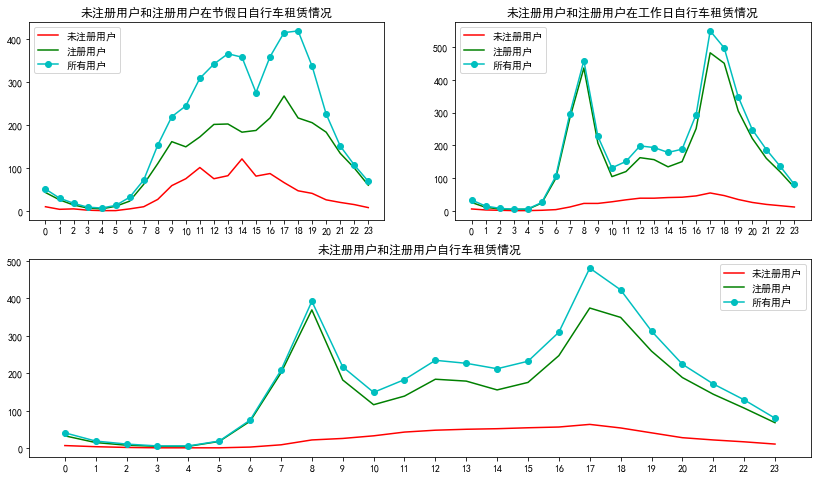

In [14]:
#绘制第一个子图
plt.figure(1, figsize=(14, 8))
plt.subplot(221)
hour_casual = df[df.holiday==1].groupby('hour')['casual'].median()
hour_registered = df[df.holiday==1].groupby('hour')['registered'].median()
hour_count = df[df.holiday==1].groupby('hour')['count'].median()
plt.plot(hour_casual.index, hour_casual.values, '-', color='r', label='未注册用户')
plt.plot(hour_registered.index, hour_registered.values, '-', color='g', label='注册用户')
plt.plot(hour_count.index, hour_count.values, '-o', color='c', label='所有用户')
plt.legend()
plt.xticks(hour_casual.index)
plt.title('未注册用户和注册用户在节假日自行车租赁情况')
#绘制第二个子图
plt.subplot(222)
hour_casual = df[df.workingday==1].groupby('hour')['casual'].median()
hour_registered = df[df.workingday==1].groupby('hour')['registered'].median()
hour_count = df[df.workingday==1].groupby('hour')['count'].median()
plt.plot(hour_casual.index, hour_casual.values, '-', color='r', label='未注册用户')
plt.plot(hour_registered.index, hour_registered.values, '-', color='g', label='注册用户')
plt.plot(hour_count.index, hour_count.values, '-o', color='c', label='所有用户')
plt.legend()
plt.xticks(hour_casual.index)
plt.title('未注册用户和注册用户在工作日自行车租赁情况')
#绘制第三个子图
plt.subplot(212)
hour_casual = df.groupby('hour')['casual'].median()
hour_registered = df.groupby('hour')['registered'].median()
hour_count = df.groupby('hour')['count'].median()
plt.plot(hour_casual.index, hour_casual.values, '-', color='r', label='未注册用户')
plt.plot(hour_registered.index, hour_registered.values, '-', color='g', label='注册用户')
plt.plot(hour_count.index, hour_count.values, '-o', color='c', label='所有用户')
plt.legend()
plt.xticks(hour_casual.index)
plt.title('未注册用户和注册用户自行车租赁情况')
plt.show()

7) 天气和总租赁数量

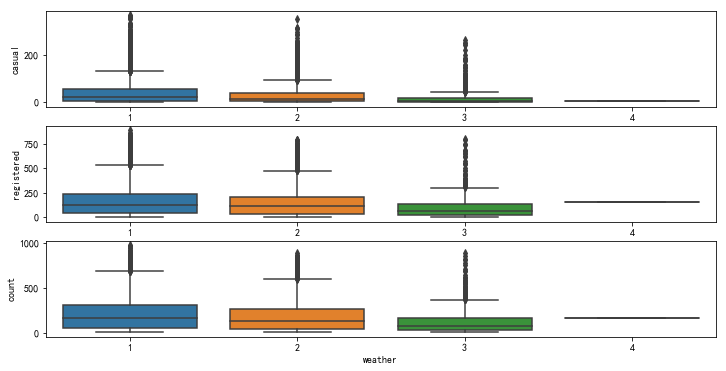

In [15]:
fig,axes=plt.subplots(nrows=3,ncols=1,figsize=(12,6))
sns.boxplot(x="weather",y="casual",data=df,ax=axes[0])
sns.boxplot(x="weather",y="registered",data=df,ax=axes[1])
sns.boxplot(x="weather",y="count",data=df,ax=axes[2])
plt.show()

In [16]:
df[df.weather==4]

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,hour,week,month,year_month,date
5631,1,0,1,4,8.2,11.365,86,6.0032,6,158,164,18,0,1,2012-01,2012-01-09


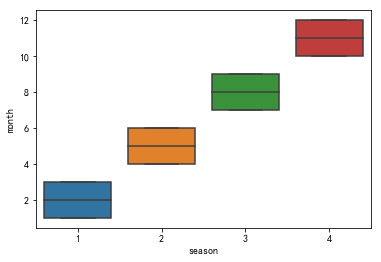

In [17]:
sns.boxplot(x='season', y='month',data=df)

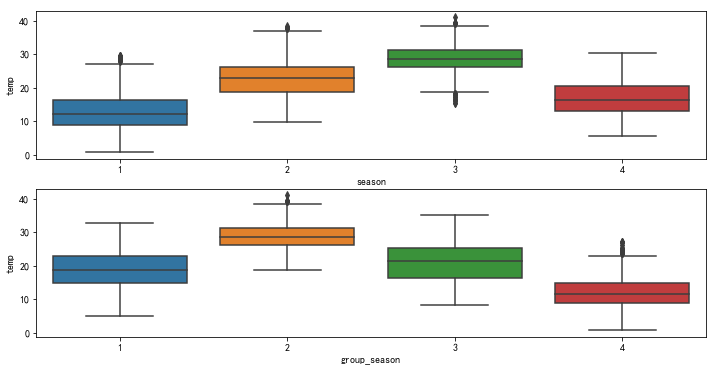

In [18]:
df["group_season"]=np.where((df.month<=5)&(df.month>=3),1,np.where((df.month<=8)&(df.month>=6),2,np.where((df.month<=11)&(df.month>=9),3,4)))
fig, ax = plt.subplots(2, 1, figsize=(12, 6))
#绘制气温和季节箱线图
sns.boxplot(x='season', y='temp',data=df, ax=ax[0])
sns.boxplot(x='group_season', y='temp',data=df, ax=ax[1])

In [19]:
df.drop('season', axis=1, inplace=True)
df.shape

(10886, 16)

8) 其他变量和总租赁数量的关系

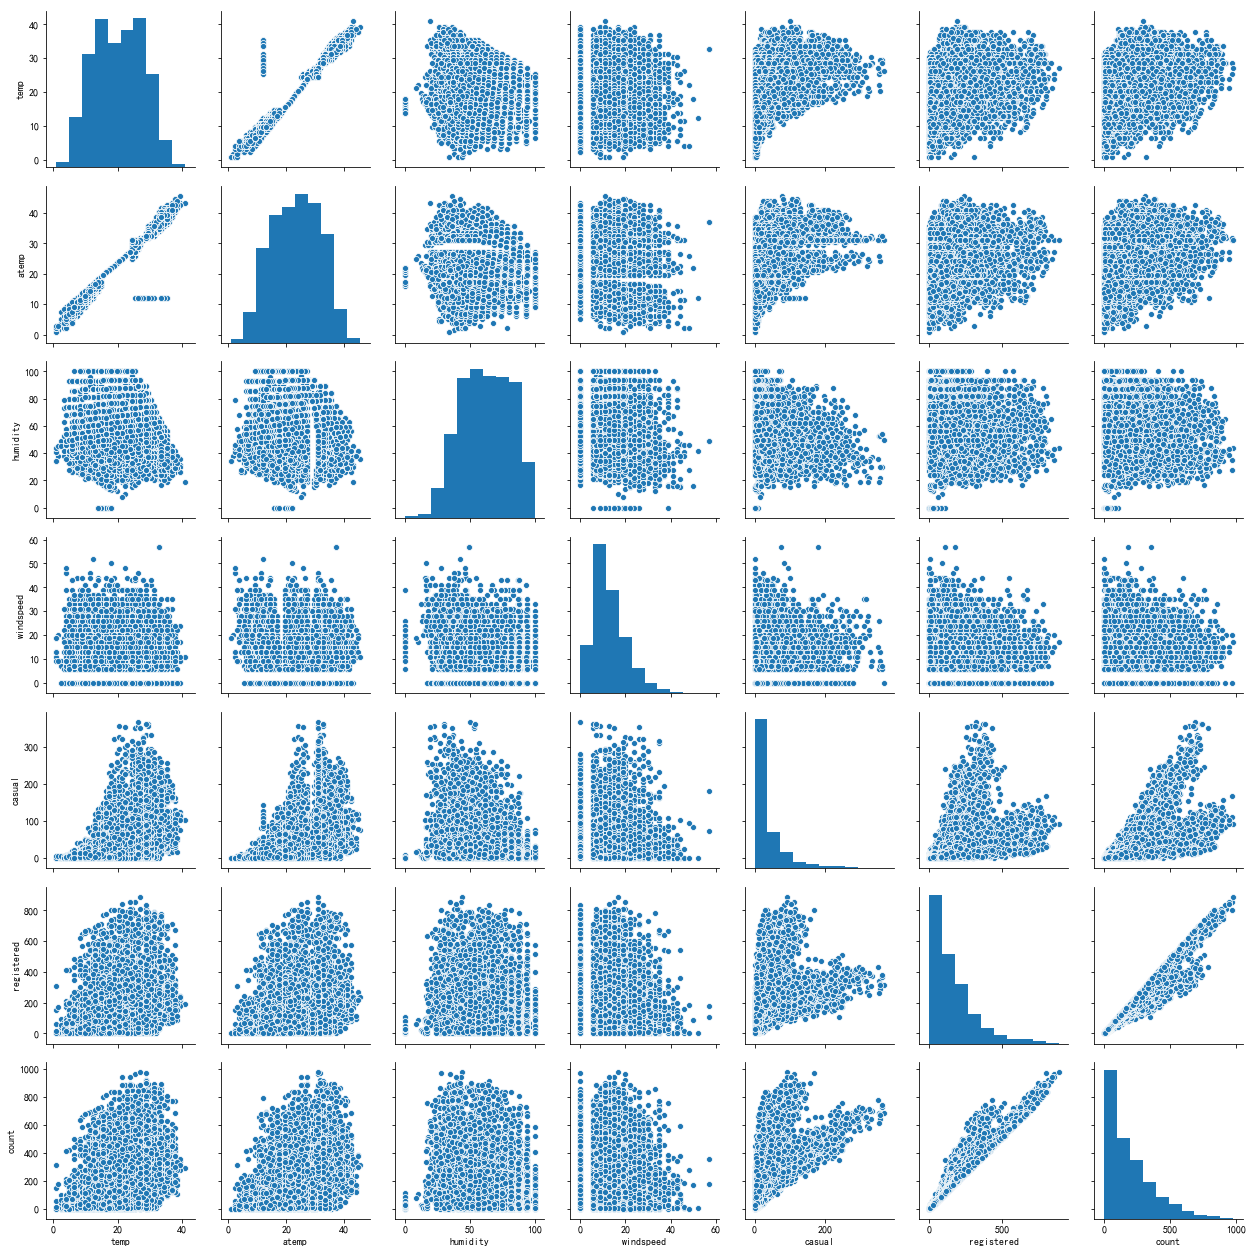

In [20]:
sns.pairplot(df[['temp', 'atemp', 'humidity', 'windspeed', 'casual', 'registered', 'count']])

In [21]:
df['windspeed']

0         0.0000
1         0.0000
2         0.0000
3         0.0000
4         0.0000
5         6.0032
6         0.0000
7         0.0000
8         0.0000
9         0.0000
10       16.9979
11       19.0012
12       19.0012
13       19.9995
14       19.0012
15       19.9995
16       19.9995
17       19.0012
18       16.9979
19       16.9979
20       16.9979
21       12.9980
22       15.0013
23       19.9995
24       19.9995
25       16.9979
26       19.0012
27       12.9980
28       12.9980
29       19.9995
30       12.9980
31       15.0013
32       15.0013
33       15.0013
34       16.9979
35       19.9995
36        8.9981
37       12.9980
38       11.0014
39       11.0014
40       12.9980
41       22.0028
42       30.0026
43       23.9994
44       22.0028
45       19.9995
46       11.0014
47       23.9994
48       27.9993
49       26.0027
50       19.0012
51       26.0027
52       12.9980
53       19.0012
54       26.0027
55       16.9979
56       22.0028
57       19.9995
58       19.00

In [22]:
df.loc[df.windspeed==0,'windspeed']=np.nan
df.fillna(method='bfill', inplace=True)
df.windspeed.isnull().sum()

0

9) 相关矩阵

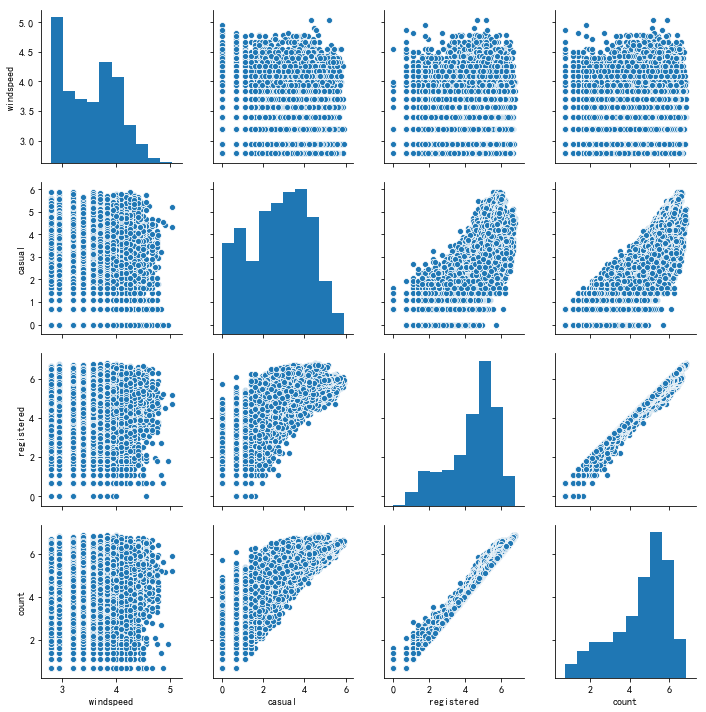

In [23]:
df['windspeed']=np.log(df['windspeed']).apply(lambda x:x+1)
df['casual'] = np.log(df['casual'].apply(lambda x: x+1))
df['registered'] = np.log(df['registered'].apply(lambda x: x+1))
df['count'] = np.log(df['count'].apply(lambda x: x+1))
sns.pairplot(df[['windspeed', 'casual', 'registered', 'count']])

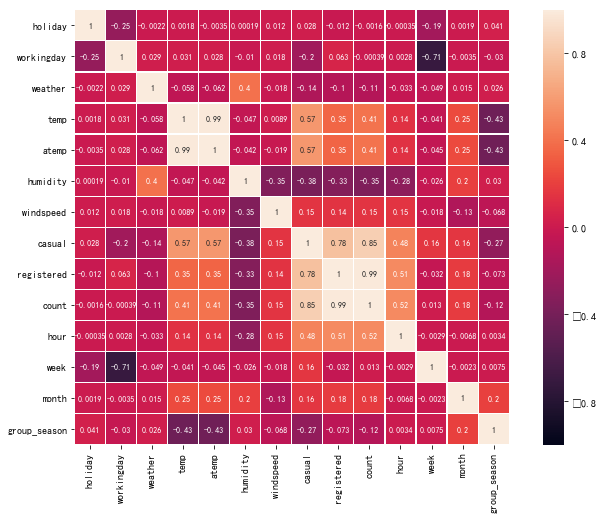

In [24]:
correlation=df.corr(method='spearman')
plt.figure(figsize=(12, 8))
#绘制热力图
sns.heatmap(correlation,vmin=-1,vmax=1,annot=True,
            annot_kws={'size':8}, linewidths=0.2, linecolor='w', square=True,)

# 5. 回归分析

5.1 岭回归
1. 划分数据集

In [25]:
from sklearn.model_selection import train_test_split
#由于所有用户的租赁数量是由未注册用户和注册用户相加而成, 故删除.
df.drop(['casual','registered'], axis=1, inplace=True)
X = df.drop(['count','year_month','date'], axis=1)
y = df['count']
#划分训练集和测试集
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

 2. 模型训练

In [26]:
from sklearn.linear_model import Ridge
#这里的alpha指的是正则化项参数, 初始先设置为1.
rd = Ridge(alpha=1)
rd.fit(X_train, y_train)
print(rd.coef_)
print(rd.intercept_)

[ 0.00763015 -0.00037812  0.00380027  0.00812089  0.03640869 -0.01558083
  0.08487086  0.09713377  0.02790865  0.06113915 -0.00094708]
2.6215765821137946


C:\Users\Feiyang\Anaconda3\lib\site-packages\matplotlib\mathtext.py:849: MathTextWarning: Font 'default' does not have a glyph for '-' [U+2212]
  MathTextWarning)
C:\Users\Feiyang\Anaconda3\lib\site-packages\matplotlib\mathtext.py:850: MathTextWarning: Substituting with a dummy symbol.
  warn("Substituting with a dummy symbol.", MathTextWarning)


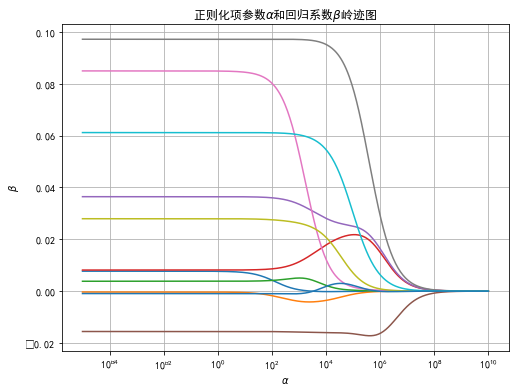

In [27]:
#设置参数以及训练模型
alphas = 10**np.linspace(-5, 10, 500)
betas = []
for alpha in alphas:
    rd = Ridge(alpha = alpha)
    rd.fit(X_train, y_train)
    betas.append(rd.coef_)
#绘制岭迹图
plt.figure(figsize=(8,6))
plt.plot(alphas, betas)
#对数据进行对数转换, 便于观察.
plt.xscale('log')
#添加网格线
plt.grid(True)
#坐标轴适应数据量
plt.axis('tight')
plt.title(r'正则化项参数$\alpha$和回归系数$\beta$岭迹图')
plt.xlabel(r'$\alpha$')
plt.ylabel(r'$\beta$')
plt.show()

In [28]:
from sklearn.linear_model import RidgeCV
from sklearn import metrics
rd_cv=RidgeCV(alphas=alphas,cv=10,scoring='r2')
rd_cv.fit(X_train,y_train)
rd_cv.alpha_

924.5531098233561

In [29]:
rd = Ridge(alpha=924.5531098233561)
rd.fit(X_train, y_train)
print(rd.coef_)
print(rd.intercept_)

[ 0.00059696 -0.00387366  0.005038    0.01109287  0.03368847 -0.01580829
  0.05500921  0.09705555  0.02629527  0.06033594 -0.0010139 ]
2.756709899194583


 4. 模型预测

In [30]:
from math import sqrt
#分别预测训练数据和测试数据
y_train_pred=rd.predict(X_train)
y_test_pred=rd.predict(X_test)
#分别计算其均方根误差和拟合优度
y_train_rmse=sqrt(metrics.mean_squared_error(y_train,y_train_pred))
y_train_score=rd.score(X_train,y_train)
y_test_rmse=sqrt(metrics.mean_squared_error(y_test,y_test_pred))
y_test_score = rd.score(X_test, y_test)
print('训练集RMSE: {0}, 评分: {1}'.format(y_train_rmse, y_train_score))
print('测试集RMSE: {0}, 评分: {1}'.format(y_test_rmse, y_test_score))

训练集RMSE: 1.0347914757802372, 评分: 0.46692939008757095
测试集RMSE: 1.0507854755418293, 评分: 0.4580355455824715


 5.2 Lasso回归
1. 模型训练

C:\Users\Feiyang\Anaconda3\lib\site-packages\matplotlib\mathtext.py:849: MathTextWarning: Font 'default' does not have a glyph for '-' [U+2212]
  MathTextWarning)
C:\Users\Feiyang\Anaconda3\lib\site-packages\matplotlib\mathtext.py:850: MathTextWarning: Substituting with a dummy symbol.
  warn("Substituting with a dummy symbol.", MathTextWarning)


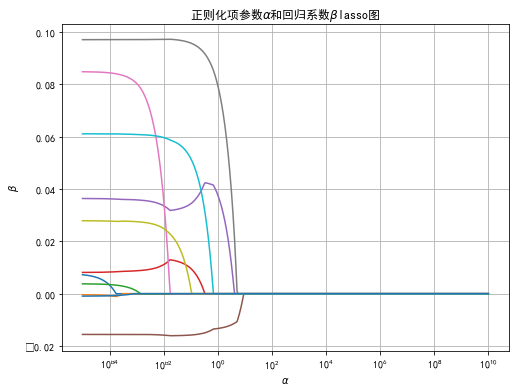

In [31]:
from sklearn.linear_model import Lasso
alphas = 10**np.linspace(-5, 10, 500)
betas = []
for alpha in alphas:
    las = Lasso(alpha = alpha)
    las.fit(X_train, y_train)
    betas.append(las.coef_)
#绘制岭迹图
plt.figure(figsize=(8,6))
plt.plot(alphas, betas)
#对数据进行对数转换, 便于观察.
plt.xscale('log')
#添加网格线
plt.grid(True)
#坐标轴适应数据量
plt.axis('tight')
plt.title(r'正则化项参数$\alpha$和回归系数$\beta$lasso图')
plt.xlabel(r'$\alpha$')
plt.ylabel(r'$\beta$')
plt.show()

In [32]:
from sklearn.linear_model import LassoCV
las_cv=LassoCV(alphas=alphas,cv=10)
las_cv.fit(X_train, y_train)
las_cv.alpha_

0.005074705239490466

In [33]:
Las = Lasso(alpha=0.005074705239490466) #, fit_intercept=False
Las.fit(X_train, y_train)
print(Las.coef_)
print(Las.intercept_)

[ 0.         -0.          0.          0.00982742  0.03484789 -0.01568115
  0.06039686  0.09720082  0.02634102  0.06034319 -0.        ]
2.728262263884555


In [34]:
#分别预测训练数据和测试数据
y_train_pred=Las.predict(X_train)
y_test_pred=Las.predict(X_test)
#分别计算其均方根误差和拟合优度
y_train_rmse=sqrt(metrics.mean_squared_error(y_train,y_train_pred))
y_train_score=rd.score(X_train,y_train)
y_test_rmse=sqrt(metrics.mean_squared_error(y_test,y_test_pred))
y_test_score = rd.score(X_test, y_test)
print('训练集RMSE: {0}, 评分: {1}'.format(y_train_rmse, y_train_score))
print('测试集RMSE: {0}, 评分: {1}'.format(y_test_rmse, y_test_score))

训练集RMSE: 1.034770370253517, 评分: 0.46692939008757095
测试集RMSE: 1.0508153141642755, 评分: 0.4580355455824715


5.3 线性回归

In [35]:
from sklearn.linear_model import LinearRegression
#训练线性回归模型
LR = LinearRegression()
LR.fit(X_train, y_train)
print(LR.coef_)
print(LR.intercept_)
#分别预测训练集和测试集, 并计算均方根误差和拟合优度
y_train_pred = LR.predict(X_train)
y_test_pred = LR.predict(X_test)
y_train_rmse = sqrt(metrics.mean_squared_error(y_train, y_train_pred))
y_train_score = LR.score(X_train, y_train)
y_test_rmse = sqrt(metrics.mean_squared_error(y_test, y_test_pred))
y_test_score = LR.score(X_test, y_test)
print('训练集RMSE: {0}, 评分: {1}'.format(y_train_rmse, y_train_score))
print('测试集RMSE: {0}, 评分: {1}'.format(y_test_rmse, y_test_score))

[ 0.00768817 -0.00035607  0.00379683  0.00811594  0.03641329 -0.01558041
  0.08492091  0.09713379  0.02791435  0.06114007 -0.00094653]
2.6213297266907523
训练集RMSE: 1.0346999722765293, 评分: 0.46702366158677433
测试集RMSE: 1.0510206175769887, 评分: 0.4577929596566015
